In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [302]:
extra_cart_df = pd.read_csv('Extra_Cart.csv', sep=',')
extra_employee_df = pd.read_csv('Extra_Employee.csv', sep=',')
employee_speed_df = pd.read_csv('Employee_Speed.csv', sep=',')


In [303]:
# Function to pivot event data
def pivot_event_data(logs_df):
    index_cols = ["customer_id", "replication_id", "seed", "base_processing_speed", "system_id"]
    index_cols = [col for col in index_cols if col in logs_df.columns]
    
    return pd.pivot_table(logs_df, index=index_cols, 
                          columns=["event_name"], values="event_time").reset_index()

# Function to compute waiting time and total time spent
def compute_times(results_df):
    results_df['Waiting_time'] = results_df['Processed'] - results_df['Arrival']
    results_df['Total_time_spent'] = results_df[['Leave', 'Left Due to Impatience']].max(axis=1) - results_df['Arrival']
    return results_df

# Function to compute interarrival times
def compute_interarrival_times(results_df):
    sort_cols = ['system_id', 'replication_id', 'Arrival']
    sort_cols = [col for col in sort_cols if col in results_df.columns]
    results_df.sort_values(by=sort_cols, inplace=True)
    
    group_cols = ['system_id', 'replication_id']
    group_cols = [col for col in group_cols if col in results_df.columns]
    results_df['iat'] = results_df.groupby(group_cols)['Arrival'].diff().fillna(0)
    return results_df

# Function to pivot queue length data and merge with results_df
def pivot_queue_length_data(logs_df, results_df):
    index_cols = ["customer_id", "replication_id", "seed", "base_processing_speed", "system_id"]
    index_cols = [col for col in index_cols if col in logs_df.columns]
    
    queue_length_df = pd.pivot_table(logs_df, index=index_cols, 
                                     columns=["event_name"], values="queue_length").reset_index()
    
    return results_df.merge(queue_length_df, on=index_cols, suffixes=('', '_queue_length'))

# Function to rename and reorder columns
def rename_and_reorder_columns(results_df):
    rename_map = {
        'Join Queue_queue_length': 'Queue_Length_At_Join'
    }
    results_df.rename(columns={k: v for k, v in rename_map.items() if k in results_df.columns}, inplace=True)
    
    # Drop unnecessary columns if they exist
    columns_to_drop = ['Queue_Join_Time']
    results_df.drop(columns=[col for col in columns_to_drop if col in results_df.columns], inplace=True)
    
    # Define the new order of columns
    new_order = ['system_id', 'customer_id', 'replication_id', 'seed', 'base_processing_speed', 'Arrival', 'Order', 'Processed', 
                 'Leave', 'Left Due to Impatience', 'Waiting_time', 'Total_time_spent', 'iat', 'Queue_Length_At_Join']
    
    # Filter out columns that do not exist in results_df
    new_order = [col for col in new_order if col in results_df.columns]
    return results_df[new_order]

# Main function to process logs and produce results DataFrame
def process_logs(logs_df):
    results_df = pivot_event_data(logs_df)
    results_df = compute_times(results_df)
    results_df = compute_interarrival_times(results_df)
    results_df = pivot_queue_length_data(logs_df, results_df)
    results_df = rename_and_reorder_columns(results_df)
    return results_df


In [304]:
def compare_queue_lengths(results_df):
    # Group by 'system_id' and 'replication_id' and calculate mean 'Queue_Length_At_Join'
    average_df = results_df.groupby(["system_id", "replication_id"]).agg(
        average_queue_length=pd.NamedAgg(column="Queue_Length_At_Join", aggfunc="mean")
    ).reset_index()

    # Extract average queue lengths for each system
    average_queue_sys1 = average_df[average_df['system_id'] == 1]['average_queue_length']
    average_queue_sys2 = average_df[average_df['system_id'] == 2]['average_queue_length']

    # Perform Levene's test for equal variances
    levene_stat, levene_p_value = levene(average_queue_sys1, average_queue_sys2)

    # Perform two-sample t-test for equal variances
    t_stat, t_p_value = ttest_ind(average_queue_sys1, average_queue_sys2, equal_var=True)

    # Calculate 95% Confidence Interval for the difference in means
    diff_mean = average_queue_sys1.mean() - average_queue_sys2.mean()
    se_diff = np.sqrt((np.var(average_queue_sys1, ddof=1) / len(average_queue_sys1)) + 
                      (np.var(average_queue_sys2, ddof=1) / len(average_queue_sys2)))
    ci_lower, ci_upper = diff_mean - 1.96 * se_diff, diff_mean + 1.96 * se_diff

    # Print results
    print(f"Levene’s test statistic: {levene_stat}")
    print(f"Levene’s test p-value: {levene_p_value}")
    print(f"Queue average of System 1: {average_queue_sys1.mean()}")
    print(f"Queue average of System 2: {average_queue_sys2.mean()}")
    print(f"95% Confidence Interval for the difference in means: ({ci_lower}, {ci_upper})")
    print(f"Two-sample t-test statistic: {t_stat}")
    print(f"Two-sample t-test p-value: {t_p_value}")

    if t_p_value < 0.05:
        print("The difference in queue lengths is statistically significant.")
    else:
        print("The difference in queue lengths is not statistically significant.")



In [305]:
import numpy as np
from scipy.stats import ttest_ind, levene, t
import pandas as pd

def compare_waiting_times(cart_results_df):
    # Group by 'system_id' and 'replication_id' and calculate mean 'Waiting_time'
    average_df = cart_results_df.groupby(["system_id", "replication_id"]).agg(
        average_time=pd.NamedAgg(column="Waiting_time", aggfunc="mean")
    ).reset_index()

    # Extract average times for each system
    average_times_sys1 = average_df[average_df['system_id'] == 1]['average_time']
    average_times_sys2 = average_df[average_df['system_id'] == 2]['average_time']

    # Perform Levene's test for equal variances
    levene_stat, levene_p_value = levene(average_times_sys1, average_times_sys2)

    # Calculate sample means
    mean_1 = average_times_sys1.mean()
    mean_2 = average_times_sys2.mean()

    # Perform two-sample t-test for equal variances
    t_stat, t_p_value = ttest_ind(average_times_sys1, average_times_sys2, equal_var=True)

    # Calculate the 95% confidence interval for the difference in means
    mean_diff = mean_1 - mean_2
    standard_err = np.sqrt((average_times_sys1.var(ddof=1) / len(average_times_sys1)) + 
                           (average_times_sys2.var(ddof=1) / len(average_times_sys2)))
    alpha = 0.05
    df = len(average_times_sys1) + len(average_times_sys2) - 2
    t_crit = t.ppf(1 - alpha / 2, df)
    ci_lower = mean_diff - t_crit * standard_err
    ci_upper = mean_diff + t_crit * standard_err

    # Print results
    print(f"Levene’s test statistic: {levene_stat}")
    print(f"Levene’s test p-value: {levene_p_value}")
    print(f"Mean of System 1: {mean_1 * 60}")
    print(f"Mean of System 2: {mean_2 * 60}")
    print(f"95% Confidence Interval for the difference in means: ({ci_lower}, {ci_upper})")
    print(f"Two-sample t-test statistic: {t_stat}")
    print(f"Two-sample t-test p-value: {t_p_value}")

    if ci_lower <= 0 <= ci_upper:
        print("The difference in means is not statistically significant.")
    else:
        print("The difference in means is statistically significant.")


### Model with an extra cart next to the Ice Cream shop

In [306]:
extra_cart_df.head()

,system_id,replication_id,seed,event_time,event_name,customer_id,queue_length,scoops,flavors,peak_hours,bucket_levels,working_employees,chosen_stand
0,1,0,71,12.000000,Working Employees,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,1,0,71,12.001481,Arrival,0.0,NaN,2.0,"['Hazelnut', 'Chocolate']",NaN,NaN,NaN,NaN
2,1,0,71,12.001481,Join Queue,0.0,1.0,NaN,NaN,NaN,NaN,NaN,Stand
3,1,0,71,12.001667,Order,0.0,NaN,2.0,"['Hazelnut', 'Chocolate']",True,NaN,NaN,NaN
4,1,0,71,12.009866,Arrival,1.0,NaN,1.0,['Mars'],NaN,NaN,NaN,NaN


In [307]:
cart_results_df = process_logs(extra_cart_df)
cart_results_df.head()

event_name,system_id,customer_id,replication_id,seed,Arrival,Order,Processed,Leave,Left Due to Impatience,Waiting_time,Total_time_spent,iat,Queue_Length_At_Join
0,1,0.0,0,71,12.001481,12.001667,12.021667,12.038333,NaN,0.020185,0.036852,0.000000,1.0
1,1,1.0,0,71,12.009866,12.010000,12.026667,12.043333,NaN,0.016801,0.033468,0.008384,1.0
2,1,2.0,0,71,12.032485,12.032500,12.049167,12.065833,NaN,0.016682,0.033348,0.022619,1.0
3,1,3.0,0,71,12.034513,12.038333,12.055000,12.071667,NaN,0.020487,0.037153,0.002028,1.0
4,1,4.0,0,71,12.061923,12.061944,12.078611,12.095278,NaN,0.016688,0.033355,0.027409,1.0


In [308]:
cart_waiting_times = compare_waiting_times(cart_results_df)
cart_waiting_times

Levene’s test statistic: 0.9980244527624994
Levene’s test p-value: 0.3347438496157099
Mean of System 1: 5.088685221508437
Mean of System 2: 5.36818667178336
95% Confidence Interval for the difference in means: (-0.02370785786681206, 0.01439114285764797)
Two-sample t-test statistic: -0.5244853131788847
Two-sample t-test p-value: 0.6081461422139798
The difference in means is not statistically significant.


In [309]:
cart_queue_length = compare_queue_lengths(cart_results_df)
cart_queue_length

Levene’s test statistic: 2.2374290754917614
Levene’s test p-value: 0.15690393354772741
Queue average of System 1: 5.006450174863433
Queue average of System 2: 3.347216233844028
95% Confidence Interval for the difference in means: (0.46812117951673415, 2.850346702522076)
Two-sample t-test statistic: 2.730302813895879
Two-sample t-test p-value: 0.016261599396203863
The difference in queue lengths is statistically significant.


In [310]:
# Group by replication_id and calculate mean and standard deviation of Waiting_time
cart_rep_wait_results = cart_results_df.groupby(["system_id", "replication_id"]).agg(
    waiting_time_mean=pd.NamedAgg(column="Waiting_time", aggfunc="mean"),
    waiting_time_std=pd.NamedAgg(column="Waiting_time", aggfunc="std"),
).reset_index()
cart_rep_wait_results["waiting_time_mean"] = cart_rep_wait_results["waiting_time_mean"] * 60
cart_rep_wait_results["waiting_time_std"] = cart_rep_wait_results["waiting_time_std"] * 60

cart_rep_wait_results.head()

,system_id,replication_id,waiting_time_mean,waiting_time_std
0,1,0,4.025942,2.331721
1,1,1,7.736092,3.805950
2,1,2,4.053102,2.563997
3,1,3,5.391749,4.107233
4,1,4,4.536692,3.684232


In [311]:
# Group by replication_id and calculate mean and standard deviation of Waiting_time
cart_rep_queue_results = cart_results_df.groupby(["system_id", "replication_id"]).agg(
    queue_length_mean=pd.NamedAgg(column="Queue_Length_At_Join", aggfunc="mean"),
    queue_length_std=pd.NamedAgg(column="Queue_Length_At_Join", aggfunc="std"),
).reset_index()
cart_rep_queue_results.head()

,system_id,replication_id,queue_length_mean,queue_length_std
0,1,0,3.619266,2.128514
1,1,1,8.498978,4.316915
2,1,2,3.993119,3.064434
3,1,3,5.204128,3.972559
4,1,4,4.267735,3.731122


<Axes: xlabel='waiting_time_mean', ylabel='Count'>

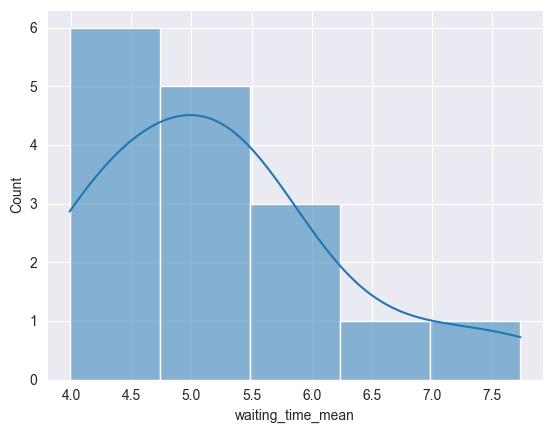

In [312]:
#plot histogram
sns.histplot(cart_rep_wait_results['waiting_time_mean'], kde=True)

In [313]:
#sort by waiting time mean (ascending)

replication_results = cart_rep_wait_results.sort_values(by='waiting_time_mean').reset_index(drop=True)
replication_results['rank'] = np.arange(1, len(replication_results) + 1)

replication_results

,system_id,replication_id,waiting_time_mean,waiting_time_std,rank
0,1,5,3.986837,3.499041,1
1,1,0,4.025942,2.331721,2
2,1,2,4.053102,2.563997,3
3,2,6,4.521059,4.525526,4
4,1,4,4.536692,3.684232,5
5,2,5,4.565070,4.207658,6
6,2,3,4.987735,4.539231,7
7,2,4,5.025398,4.671482,8
8,2,7,5.218902,4.121638,9
9,1,6,5.381552,4.059754,10


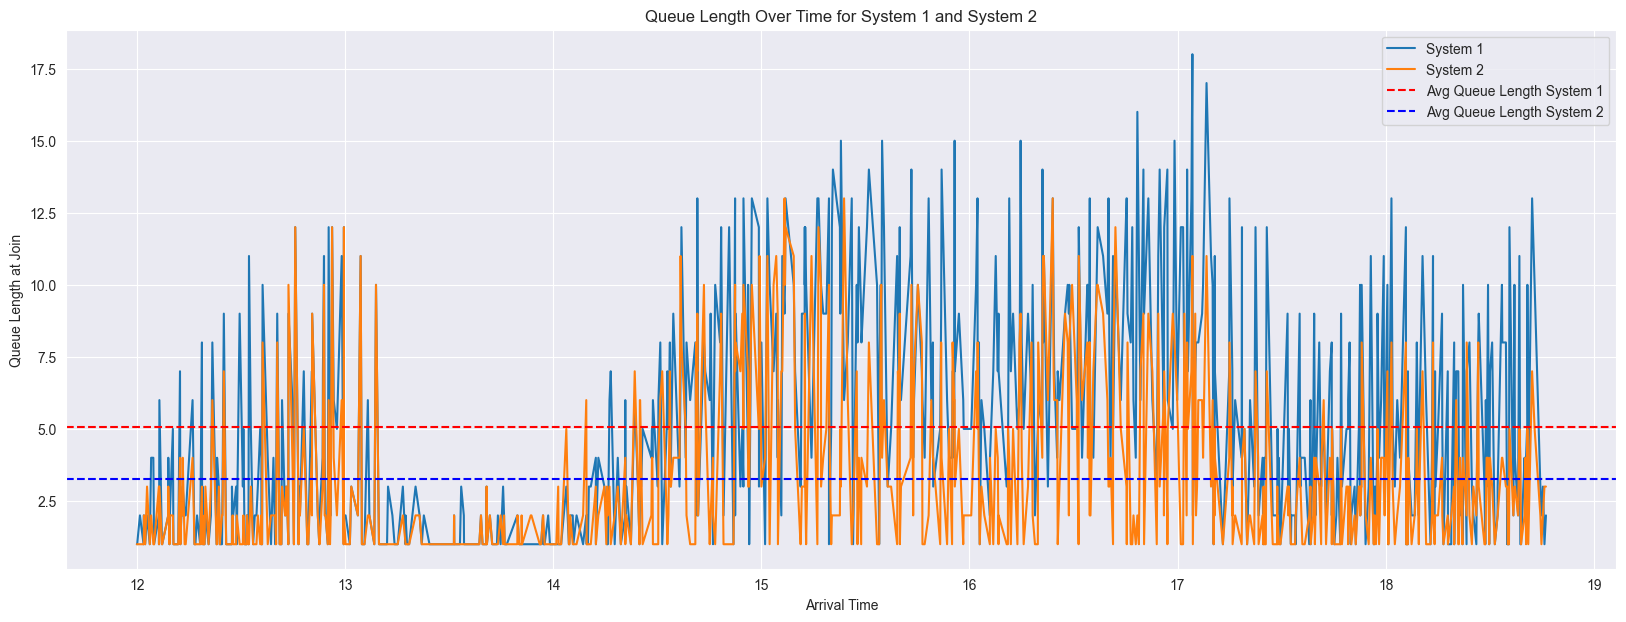

In [314]:
# Assuming results_df is already defined and contains the simulation results
# Get only the queue_monitor events
queue_data = cart_results_df[['system_id', 'replication_id', 'Arrival', 'Queue_Length_At_Join']]

# Filter the data to get only the events from system 1 and system 2
queue_data_1 = queue_data[queue_data['system_id'] == 1]
queue_data_2 = queue_data[queue_data['system_id'] == 2]

# Keep only every 5th data point
queue_data_1 = queue_data_1.iloc[::5, :]
queue_data_2 = queue_data_2.iloc[::5, :]

# Calculate the average queue length for each system
avg_queue_length_1 = queue_data_1['Queue_Length_At_Join'].mean()
avg_queue_length_2 = queue_data_2['Queue_Length_At_Join'].mean()

# Set figure size
f, ax = plt.subplots(1, figsize=(20, 7))

# Plot the queue length over time for both systems
sns.lineplot(data=queue_data_1, x='Arrival', y='Queue_Length_At_Join', ax=ax, label='System 1')
sns.lineplot(data=queue_data_2, x='Arrival', y='Queue_Length_At_Join', ax=ax, label='System 2')

# Plot the average queue length lines
ax.axhline(avg_queue_length_1, color='red', linestyle='--', label='Avg Queue Length System 1')
ax.axhline(avg_queue_length_2, color='blue', linestyle='--', label='Avg Queue Length System 2')

# Set the title and labels
ax.set_title('Queue Length Over Time for System 1 and System 2')
ax.set_xlabel('Arrival Time')
ax.set_ylabel('Queue Length at Join')

# Show the plot
plt.legend()
plt.show()


In [315]:
#Compute the point estimate of the mean queue length accross replications
mean_queue_data = queue_data.groupby('system_id')['Queue_Length_At_Join'].mean()

#Compute the point estimate of the mean queue length accross replications
point_estimator = mean_queue_data.mean()
point_estimator

np.float64(4.212846347607053)

### Analysis of the model with an extra full time employee


In [316]:
employee_results_df = process_logs(extra_employee_df)
employee_results_df.head()

event_name,system_id,customer_id,replication_id,seed,Arrival,Order,Processed,Leave,Left Due to Impatience,Waiting_time,Total_time_spent,iat,Queue_Length_At_Join
0,1,0.0,0,35,12.010467,12.010556,12.027222,12.043889,NaN,0.016755,0.033422,0.000000,1.0
1,1,1.0,0,35,12.016433,12.016667,12.036667,12.053333,NaN,0.020234,0.036900,0.005966,1.0
2,1,2.0,0,35,12.019741,12.020000,12.043333,12.060000,NaN,0.023592,0.040259,0.003308,1.0
3,1,3.0,0,35,12.024682,12.043889,12.063889,12.080556,NaN,0.039207,0.055873,0.004941,1.0
4,1,4.0,0,35,12.046654,12.053333,12.070000,12.086667,NaN,0.023346,0.040012,0.021972,1.0


In [317]:
employee_waiting_times = compare_waiting_times(employee_results_df)
employee_waiting_times

Levene’s test statistic: 5.893825746662734
Levene’s test p-value: 0.03558867691923914
Mean of System 1: 4.298211513622858
Mean of System 2: 1.4055007142936566
95% Confidence Interval for the difference in means: (0.028988696479730614, 0.06743499683124278)
Two-sample t-test statistic: 5.588193801531317
Two-sample t-test p-value: 0.00023145413819658267
The difference in means is statistically significant.


In [318]:
employee_queue_length = compare_queue_lengths(employee_results_df)
employee_queue_length

Levene’s test statistic: 5.984924326347573
Levene’s test p-value: 0.03446884516546128
Queue average of System 1: 4.27323318448012
Queue average of System 2: 1.3287641164064479
95% Confidence Interval for the difference in means: (1.6723403622984867, 4.216597773848859)
Two-sample t-test statistic: 4.536615947132235
Two-sample t-test p-value: 0.0010803213398545418
The difference in queue lengths is statistically significant.


In [319]:
# Group by replication_id and calculate mean and standard deviation of Waiting_time
emp_rep_wait_results = employee_results_df.groupby(["system_id", "replication_id"]).agg(
    waiting_time_mean=pd.NamedAgg(column="Waiting_time", aggfunc="mean"),
    waiting_time_std=pd.NamedAgg(column="Waiting_time", aggfunc="std"),
).reset_index()
emp_rep_wait_results["waiting_time_mean"] = emp_rep_wait_results["waiting_time_mean"] * 60
emp_rep_wait_results["waiting_time_std"] = emp_rep_wait_results["waiting_time_std"] * 60

emp_rep_wait_results.head()

,system_id,replication_id,waiting_time_mean,waiting_time_std
0,1,0,2.733899,1.572894
1,1,1,6.355671,3.588035
2,1,2,4.609055,3.423752
3,1,3,3.228738,2.292399
4,1,4,4.273405,2.543848


In [320]:
# Group by replication_id and calculate mean and standard deviation of Waiting_time
emp_rep_queue_results = employee_results_df.groupby(["system_id", "replication_id"]).agg(
    queue_length_mean=pd.NamedAgg(column="Queue_Length_At_Join", aggfunc="mean"),
    queue_length_std=pd.NamedAgg(column="Queue_Length_At_Join", aggfunc="std"),
).reset_index()
emp_rep_queue_results.head()

,system_id,replication_id,queue_length_mean,queue_length_std
0,1,0,2.614679,2.076284
1,1,1,7.023504,4.638250
2,1,2,4.561247,3.890397
3,1,3,2.840183,2.107420
4,1,4,4.049327,2.391424


<Axes: xlabel='waiting_time_mean', ylabel='Count'>

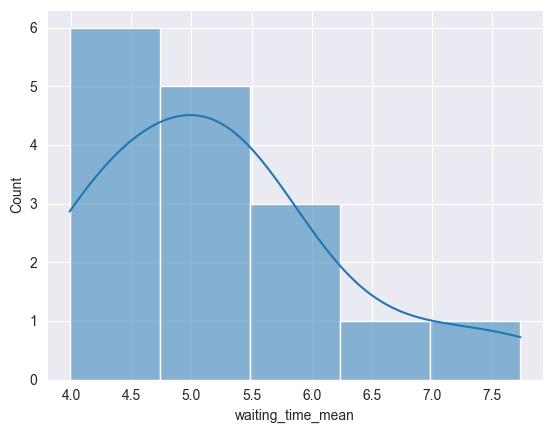

In [321]:
#plot histogram
sns.histplot(cart_rep_wait_results['waiting_time_mean'], kde=True)

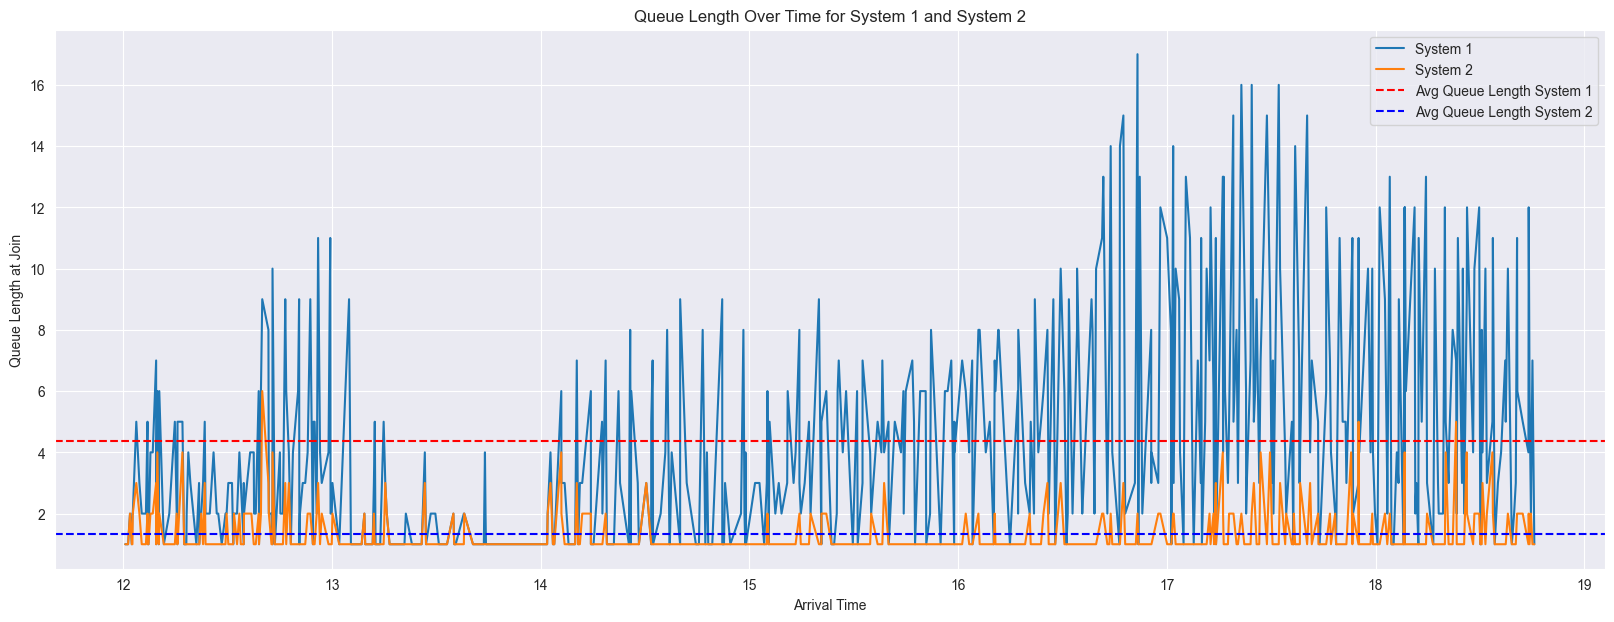

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming results_df is already defined and contains the simulation results
# Get only the queue_monitor events
queue_data = employee_results_df[['system_id', 'replication_id', 'Arrival', 'Queue_Length_At_Join']]

# Filter the data to get only the events from system 1 and system 2
queue_data_1 = queue_data[queue_data['system_id'] == 1]
queue_data_2 = queue_data[queue_data['system_id'] == 2]

# Keep only every 5th data point
queue_data_1 = queue_data_1.iloc[::5, :]
queue_data_2 = queue_data_2.iloc[::5, :]

# Calculate the average queue length for each system
avg_queue_length_1 = queue_data_1['Queue_Length_At_Join'].mean()
avg_queue_length_2 = queue_data_2['Queue_Length_At_Join'].mean()

# Set figure size
f, ax = plt.subplots(1, figsize=(20, 7))

# Plot the queue length over time for both systems
sns.lineplot(data=queue_data_1, x='Arrival', y='Queue_Length_At_Join', ax=ax, label='System 1')
sns.lineplot(data=queue_data_2, x='Arrival', y='Queue_Length_At_Join', ax=ax, label='System 2')

# Plot the average queue length lines
ax.axhline(avg_queue_length_1, color='red', linestyle='--', label='Avg Queue Length System 1')
ax.axhline(avg_queue_length_2, color='blue', linestyle='--', label='Avg Queue Length System 2')

# Set the title and labels
ax.set_title('Queue Length Over Time for System 1 and System 2')
ax.set_xlabel('Arrival Time')
ax.set_ylabel('Queue Length at Join')

# Show the plot
plt.legend()
plt.show()


In [334]:
#Compute the point estimate of the mean queue length accross replications
mean_queue_data = queue_data.groupby('system_id')['Queue_Length_At_Join'].mean()

#Compute the point estimate of the mean queue length accross replications
point_estimator = mean_queue_data.mean()
point_estimator

np.float64(2.8178077066965956)

## Model with different employee speeds

In [323]:
speed_results_df = process_logs(employee_speed_df)
speed_results_df = speed_results_df.dropna(subset=['Waiting_time'])

speed_results_df.head()

event_name,customer_id,replication_id,seed,base_processing_speed,Arrival,Order,Processed,Leave,Left Due to Impatience,Waiting_time,Total_time_spent,iat,Queue_Length_At_Join
0,0.0,0,41,30.0,12.004018,12.004167,12.012500,12.029167,NaN,0.008482,0.025149,0.0,1.0
1,0.0,0,41,36.0,12.004018,12.004167,12.017500,12.034167,NaN,0.013482,0.030149,0.0,1.0
2,0.0,0,41,42.0,12.004018,12.004167,12.015833,12.032500,NaN,0.011815,0.028482,0.0,1.0
3,0.0,0,41,48.0,12.004018,12.004167,12.024167,12.040833,NaN,0.020149,0.036815,0.0,1.0
4,0.0,0,41,54.0,12.004018,12.004167,12.019167,12.035833,NaN,0.015149,0.031815,0.0,1.0


In [324]:
# Group by base processing speed and replication_id and calculate average waiting time
speed_average_df = speed_results_df.groupby(['base_processing_speed', 'replication_id']).agg(
    average_time=pd.NamedAgg(column='Waiting_time', aggfunc='mean')
).reset_index()

speed_average_df['base_processing_speed'] = speed_average_df['base_processing_speed'].round(1)
speed_average_df

,base_processing_speed,replication_id,average_time
0,30.0,0,0.017637
1,30.0,1,0.021356
2,30.0,2,0.018867
3,30.0,3,0.017556
4,30.0,4,0.018612
5,36.0,0,0.023271
6,36.0,1,0.025140
7,36.0,2,0.023994
8,36.0,3,0.023442
9,36.0,4,0.021722


In [325]:
# Convert average time from hours to minutes
speed_average_df['average_time_minutes'] = speed_average_df['average_time'] * 60
speed_results_df['Waiting_time_minutes'] = speed_results_df['Waiting_time'] * 60

# Check for equality of variances using Levene's test
levene_stat, levene_p_value = levene(
    *[speed_average_df[speed_average_df['base_processing_speed'] == speed]['average_time_minutes'].values 
      for speed in speed_average_df['base_processing_speed'].unique()]
)

print(f"Levene’s test statistic: {levene_stat}")
print(f"Levene’s test p-value: {levene_p_value}")


Levene’s test statistic: 0.7716932345496226
Levene’s test p-value: 0.615161500908236


In [326]:
# Perform ANOVA to test if there are significant differences in average waiting times
anova_result = stats.f_oneway(
    *[group['average_time'].values for name, group in speed_average_df.groupby('base_processing_speed')]
)

print(f"ANOVA F-statistic: {anova_result.statistic}")
print(f"ANOVA p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There are significant differences in waiting times across processing speeds.")
else:
    print("Fail to reject the null hypothesis: No significant differences in waiting times across processing speeds.")


ANOVA F-statistic: 110.73249484327275
ANOVA p-value: 1.3511575735969652e-20
Reject the null hypothesis: There are significant differences in waiting times across processing speeds.


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  30.0   36.0   0.2825 0.9934 -0.9001 1.4651  False
  30.0   42.0   0.7523   0.46 -0.4303 1.9349  False
  30.0   48.0    1.578 0.0031  0.3954 2.7606   True
  30.0   54.0   2.4855    0.0  1.3029 3.6681   True
  30.0   60.0     3.97    0.0  2.7874 5.1526   True
  30.0   66.0   5.7537    0.0  4.5711 6.9363   True
  30.0   72.0   7.4478    0.0  6.2652 8.6304   True
  36.0   42.0   0.4698 0.8971 -0.7128 1.6524  False
  36.0   48.0   1.2955 0.0238  0.1129 2.4781   True
  36.0   54.0    2.203    0.0  1.0204 3.3856   True
  36.0   60.0   3.6875    0.0  2.5049 4.8701   True
  36.0   66.0   5.4712    0.0  4.2886 6.6539   True
  36.0   72.0   7.1653    0.0  5.9827 8.3479   True
  42.0   48.0   0.8257 0.3445 -0.3569 2.0083  False
  42.0   54.0   1.7332  0.001  0.5506 2.9158   True
  42.0   60.0   3.2177    0.0  2.0351 4.4003   True
  42.0   66.

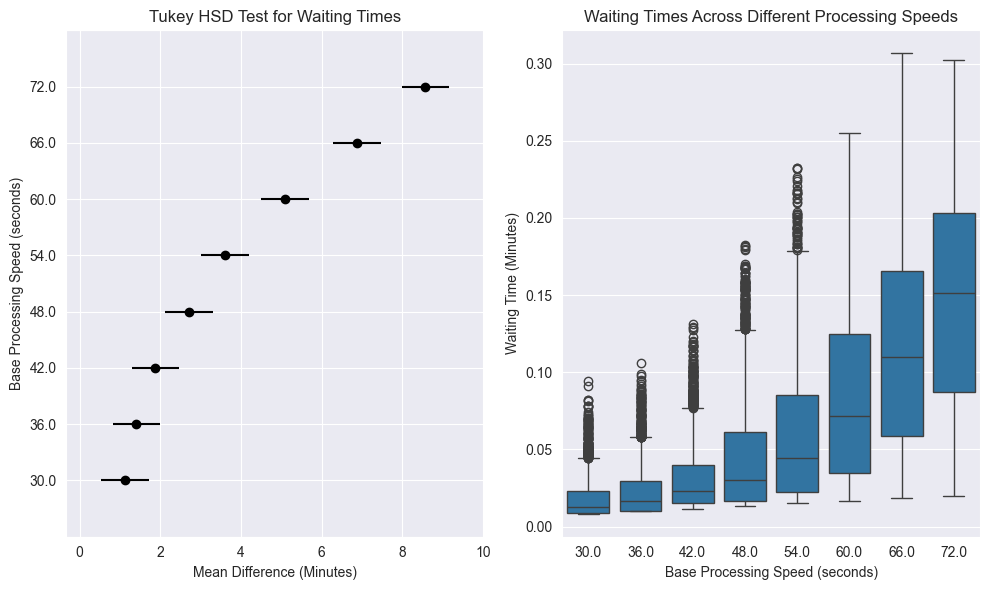

In [327]:

# Perform Tukey's HSD test for waiting times in minutes
tukey_waiting = pairwise_tukeyhsd(endog=speed_average_df['average_time_minutes'], 
                                  groups=speed_average_df['base_processing_speed'], 
                                  alpha=0.05)

print(tukey_waiting)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the Tukey HSD test results on the first subplot
tukey_waiting.plot_simultaneous(ax=axs[0])
axs[0].set_title('Tukey HSD Test for Waiting Times')
axs[0].set_xlabel('Mean Difference (Minutes)')
axs[0].set_ylabel('Base Processing Speed (seconds)')

# Visualize the distribution of waiting times across different processing speeds
speed_results_df['base_processing_speed'] = speed_results_df['base_processing_speed'].round(1)
# speed_results_df['Waiting_time'] = speed_results_df['Waiting_time'] * 60

sns.boxplot(x='base_processing_speed', y='Waiting_time', data=speed_results_df, ax=axs[1])
axs[1].set_title('Waiting Times Across Different Processing Speeds')
axs[1].set_xlabel('Base Processing Speed (seconds)')
axs[1].set_ylabel('Waiting Time (Minutes)')

# Adjust layout
plt.tight_layout()
plt.show()


In [328]:
# Group by base processing speed and replication_id and calculate average queue length
speed_average_queue_df = speed_results_df.groupby(['base_processing_speed', 'replication_id']).agg(
    average_queue_length=pd.NamedAgg(column='Queue_Length_At_Join', aggfunc='mean')
).reset_index()
speed_average_queue_df['base_processing_speed'] = speed_average_queue_df['base_processing_speed'].round(1)
speed_average_queue_df.head()

,base_processing_speed,replication_id,average_queue_length
0,30.0,0,1.424947
1,30.0,1,1.619590
2,30.0,2,1.515351
3,30.0,3,1.377880
4,30.0,4,1.427928


In [329]:
# Check for equality of variances using Levene's test
levene_stat, levene_p_value = levene(
    *[speed_average_queue_df[speed_average_queue_df['base_processing_speed'] == speed]['average_queue_length'].values 
      for speed in speed_average_queue_df['base_processing_speed'].unique()]
)

print(f"Levene’s test statistic: {levene_stat}")
print(f"Levene’s test p-value: {levene_p_value}")


Levene’s test statistic: 0.8619772369794365
Levene’s test p-value: 0.5463117686007497


In [330]:
# Perform ANOVA to test if there are significant differences in average queue lengths
speed_anova_queue_result = stats.f_oneway(
    *[group['average_queue_length'].values for name, group in speed_average_queue_df.groupby('base_processing_speed')]
)

print(f"ANOVA F-statistic for queue lengths: {speed_anova_queue_result.statistic}")
print(f"ANOVA p-value for queue lengths: {speed_anova_queue_result.pvalue}")

if speed_anova_queue_result.pvalue < 0.05:
    print("Reject the null hypothesis: There are significant differences in queue lengths across processing speeds.")
else:
    print("Fail to reject the null hypothesis: No significant differences in queue lengths across processing speeds.")


ANOVA F-statistic for queue lengths: 66.31109786327836
ANOVA p-value for queue lengths: 3.054165436294213e-17
Reject the null hypothesis: There are significant differences in queue lengths across processing speeds.


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  30.0   36.0   0.1804 0.9999 -1.3157 1.6764  False
  30.0   42.0   0.5568 0.9243 -0.9393 2.0529  False
  30.0   48.0   1.3076 0.1225 -0.1885 2.8037  False
  30.0   54.0   2.1466 0.0013  0.6506 3.6427   True
  30.0   60.0   3.6829    0.0  2.1868  5.179   True
  30.0   66.0   5.5414    0.0  4.0454 7.0375   True
  30.0   72.0   7.1849    0.0  5.6888  8.681   True
  36.0   42.0   0.3764  0.991 -1.1196 1.8725  False
  36.0   48.0   1.1273  0.257 -0.3688 2.6233  False
  36.0   54.0   1.9663 0.0037  0.4702 3.4624   True
  36.0   60.0   3.5025    0.0  2.0064 4.9986   True
  36.0   66.0   5.3611    0.0   3.865 6.8572   True
  36.0   72.0   7.0046    0.0  5.5085 8.5006   True
  42.0   48.0   0.7508 0.7319 -0.7452 2.2469  False
  42.0   54.0   1.5899 0.0309  0.0938 3.0859   True
  42.0   60.0   3.1261    0.0    1.63 4.6222   True
  42.0   66.

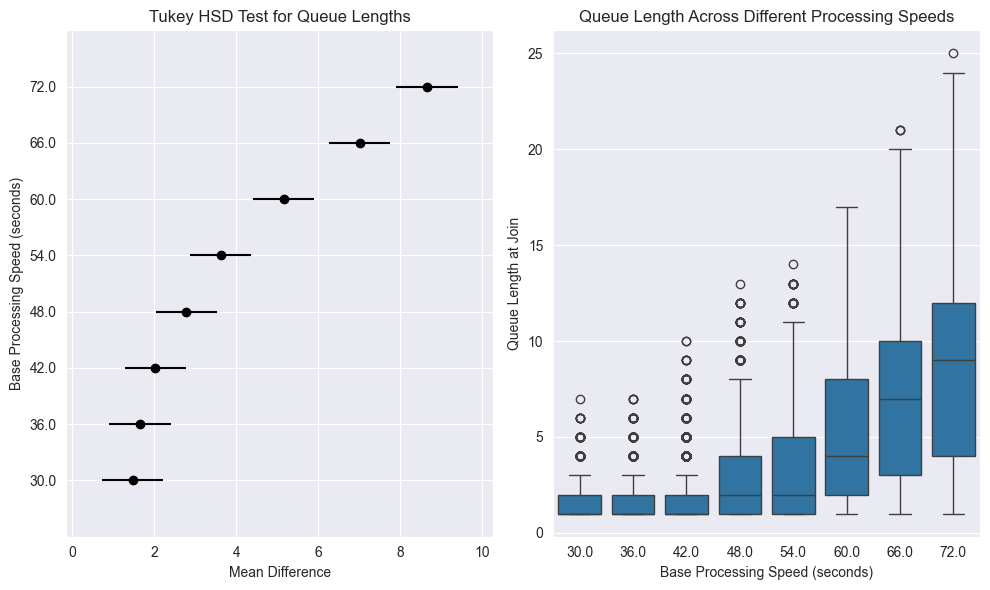

In [331]:
# Perform Tukey's HSD test for waiting times in minutes
tukey_queue = pairwise_tukeyhsd(endog=speed_average_queue_df['average_queue_length'], 
                                  groups=speed_average_queue_df['base_processing_speed'], 
                                  alpha=0.05)

print(tukey_queue)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the Tukey HSD test results on the first subplot
tukey_queue.plot_simultaneous(ax=axs[0])
axs[0].set_title('Tukey HSD Test for Queue Lengths')
axs[0].set_xlabel('Mean Difference')
axs[0].set_ylabel('Base Processing Speed (seconds)')

sns.boxplot(x='base_processing_speed', y='Queue_Length_At_Join', data=speed_results_df, ax=axs[1])
axs[1].set_title('Queue Length Across Different Processing Speeds')
axs[1].set_xlabel('Base Processing Speed (seconds)')
axs[1].set_ylabel('Queue Length at Join')

# Adjust layout
plt.tight_layout()
plt.show()

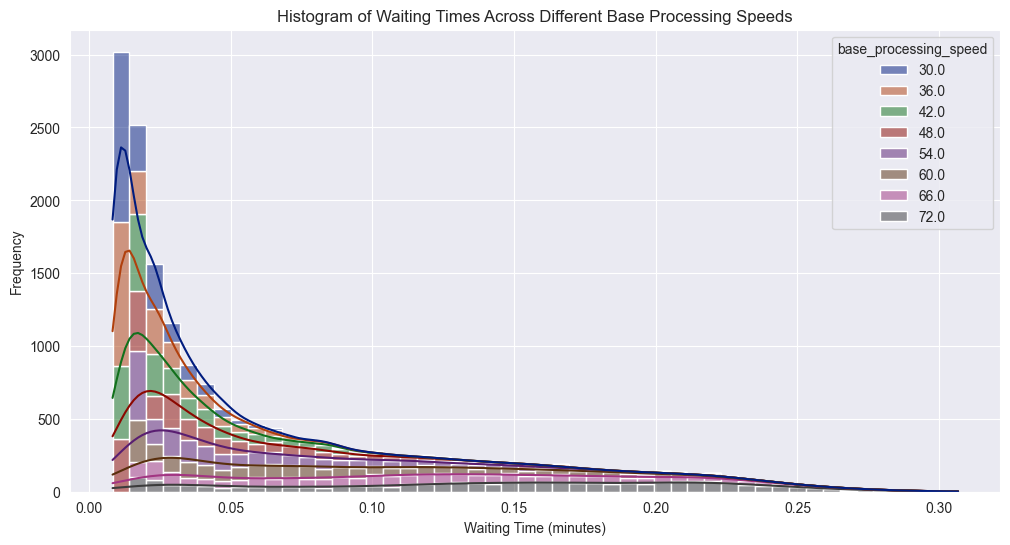

In [332]:
# Plot histogram of waiting times with different colors for each base speed
plt.figure(figsize=(12, 6))
sns.histplot(data=speed_results_df, x='Waiting_time', hue='base_processing_speed', multiple='stack', kde=True, palette='dark')
plt.title('Histogram of Waiting Times Across Different Base Processing Speeds')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.show()


Intercept: -5.19248405050297
Coefficient: 0.17851834676421782
R^2 score: 0.4220749438462369


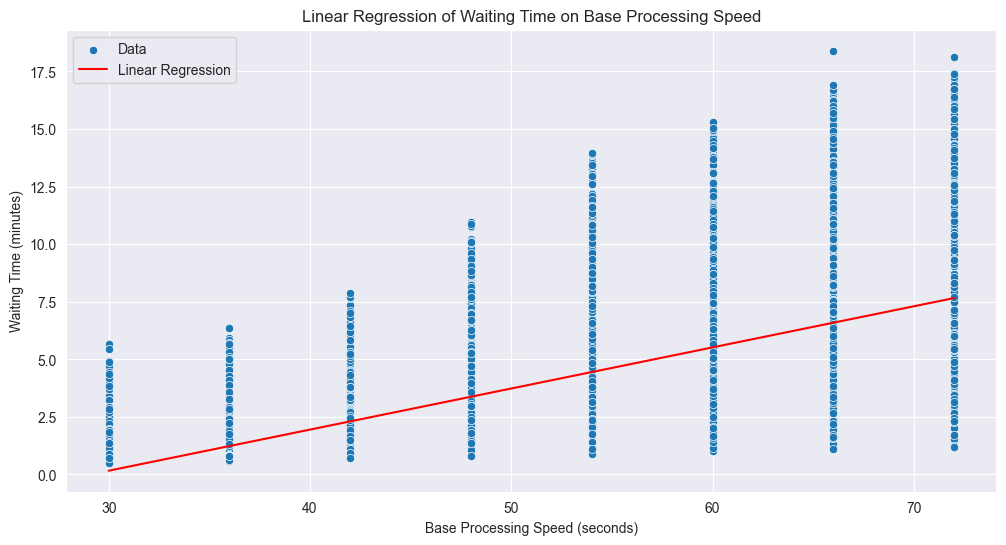

In [333]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data for linear regression
X = speed_results_df[['base_processing_speed']].values
y = speed_results_df['Waiting_time_minutes'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict waiting times
y_pred = model.predict(X)

# Calculate R^2 score
r2 = r2_score(y, y_pred)

# Print the coefficients and R^2 score
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")
print(f"R^2 score: {r2}")

# Plot the data and the regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(x='base_processing_speed', y='Waiting_time_minutes', data=speed_results_df, label='Data')
plt.plot(speed_results_df['base_processing_speed'], y_pred, color='red', label='Linear Regression')
plt.title('Linear Regression of Waiting Time on Base Processing Speed')
plt.xlabel('Base Processing Speed (seconds)')
plt.ylabel('Waiting Time (minutes)')
plt.legend()
plt.show()
